# Next-Event Simulation Assignment
### Year 2017-2018  - Semester II
### CCE3501 / CCE3502
#### Originally devloped by - Adrian Muscat, 2018
---

# Franklyn Sciberras
# 0441498M 
# BSc CS, Yr II
---



In this assignment you will be simulating a multiserver system with a limited buffer queue at each server. As an example you will consider a car share system. Such systems operate like self drive car hire systems, however the customer hires the car for the duration of the trip only. Car share company owns a number of parking lots and customers pick up and drop off cars at these designated parking lots.

Overall you will be setting up a Next Event Simulation to model the system. You will save the values for some variables and validate the simulation using statistics. We are not interested in tracking the individual customers and therefore pre-booking is not allowed. Instead we are interested in how many requests are serviced, how many are blocked, the average waiting time, and quality of service versus cost (vehicle fleet size).  

#### Assumptions
1. System variables are defined in the below scripts.
1. The location of the parking lots (three in number) are predefined and the distances are given in a matrix.
1. A request is blocked if queue at server is longer than maximum buffer length.
1. Assume exponential inter-arrival time for requests (code given).
1. Assume service time depends on distance travelled (code given).
1. Time of travel is constant throughout the day.
1. Customers travel from one parking lot to another and do not stop at any intermediate location.



#### Tasks and Questions  (repeated below at the appropriate position)
1. Take note of the system variables declared 
1. Take note of the network of the spatial distribution of the five parking lots and time of travel 
1. Sketch a system diagram, showing the three servers and associated queues (it is useful to depict the servers at the right geographical position)    
1. Formulate and code request_arrival routine
1. Formulate and code begin_service routine
1. Formulate and code end_service routine
2. Complete the main simulation function
2. Check the final values for variables N and Q
2. Compute Blocking Rate
2. Plot the number of customers queing at parking lot (1) versus time
2. Run the simulation N times and find the mean and standard deviation



In [145]:
import random, math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [146]:
# this line plots graphs in line
%matplotlib inline

## Take note of the network of the spatial distribution of the three parking lots and time of travel from one node to another

In [147]:
# DO NOT MODIFY THIS CELL

def InterArrivalTime():
    # exponential arrivals
    mean = 0.01  # units=hours
    return -mean*math.log(random.random())

def get_trip_time(N1,N2):
    v=25.0  # average vehicle speed = km/hr
    d = np.sqrt((service_node[N1,0]-service_node[N2,0])**2.0 + (service_node[N1,1]-service_node[N2,1])**2.0)
    return d/v

# Service area 10km x 10km
service_node = np.array([[1,1], 
                 [9,5], 
                 [3,9]])
#
Z = np.shape(service_node)[0]           # number of nodes
#
time_to_travel=np.empty([Z,Z],dtype=float)
for i in range(Z):
    for j in range(Z):
        time_to_travel[i,j]=get_trip_time(i,j)
#

## Take note of the system variables declared

In [148]:
# Simulation Variables
# initialize
fileOutA=True   # Flag, if true add to stateVarList
stateVarList=[]    # List containing [time, N(t), Q(t)]
servTimeList=[]
eventList=[]    # Event calendar list
notice=[]       # notice = [ notice number, time, type, [parameters] ]
                # type = 0, arrival
                # type = 1, begin service
                # type = 2, end service
                # param 0 = orgin/destination node
now = 0.0       # Simulation time
#
end_of_sim = 12.0 # time end of generating requests
#

#
Qmax=3          # request blocked if Q=>Qmax
Q=[]            # Queue Length at node z, Q=0 when empty
for i in range(Z):
    Q.append(0)
N=[]            # Number of resources at node z
for i in range(Z):
    N.append(10)


## TASK: Sketch a system diagram, showing the three servers and associated queues 
### (it is useful to depict the servers at the right geographical position)

In [149]:
# DO NOT MODIFY THIS CELL
# add event notice to calendar (event list)
# event notices are ordered in time
def ScheduleEventNotice(notice):
    global eventList
    if len(eventList)==0:
        eventList.append(notice)
    elif len(eventList)==1:
        #if time of new notice occurs after first existing notice, append new notice at end of list
        if eventList[0][1] <= notice[1]:
            eventList.append(notice)
        #else insert it at position zero and move the notice at position zero to position one
        else:
            eventList.insert(0,notice)
    #if it contains more than one item, check the last notice and compare its time with the time of the new notice
    #if it new notice occurs after last item append it to the end of the list
    elif eventList[len(eventList)-1][1] < notice[1]:
        eventList.append(notice)
    #else search for the notice in the list which occurs after the new notice, and insert the new notice prior to it
    else:
        i=0
        while (eventList[i][1]<=notice[1] and i<(len(eventList)-1)):
            i += 1
        eventList.insert(i,notice)

In [150]:
# DO NOT MODIFY THIS CELL

# save variables for output processing in a list
def WriteToOutputList():
    stateEntry = [now, list(N), list(Q)]  # ****
    stateVarList.append(stateEntry)

# Debug script 
def DisplayEventList(header):
    print header
    i=0
    while i<len(eventList):
        print eventList[i]
        i += 1

# Debug Script
def DisplayStateList(header):
    print header
    i=0
    while i<len(stateVarList):
        print stateVarList[i]
        i += 1

In [151]:
# DO NOT MODIFY THIS CELL

def ODServiceTime(x,y):
    return time_to_travel[x,y]

def generate_Origin_node(Nmax):
    #Nmax is an integer equal to the number of nodes in system
    Nrange=range(int(Nmax))
    idx=np.random.randint(low=0,high=len(Nrange))
    origin = Nrange[idx]
    return origin

def generate_Destination_node(Nmax,origin_node):
    #Nmax is an integer equal to the number of nodes in system
    Nrange=range(int(Nmax))
    Nrange.remove(origin_node)
    idx=np.random.randint(low=0,high=len(Nrange))
    destination = Nrange[idx]
    return destination

#not using this
def generate_OD_tuple(Nmax):
    #Nmax is an integer equal to the number of nodes in system
    Nrange=range(int(Nmax))
    idx=np.random.randint(low=0,high=len(Nrange))
    origin = Nrange[idx]
    Nrange.remove(Nrange[idx])
    idx=np.random.randint(low=0,high=len(Nrange))
    destination = Nrange[idx]
    return [origin,destination]

## TASK : Formulate and code Event_Routine_Arrival

In [152]:
def EventRoutineArrival(P): # P are the parameters in the event notice
    global EN, N, Q, Z, tot_no_arrivals, blocked, Blocked
    tot_no_arrivals+=1
    if now < end_of_sim:
        EN+=1
        Notice = [EN, now+(InterArrivalTime()),0,[generate_Origin_node(Z)]]
        ScheduleEventNotice(Notice)
    if Q[P[0]] < Qmax:
        Q[P[0]]+=1
        if N[P[0]]>0:
            EN+=1
            Notice = [EN,now,1,[P[0]]]
            ScheduleEventNotice(Notice)
    else:
        Blocked[P[0]] +=1
        blocked+=1
    WriteToOutputList()


## TASK : Formulate and code Event_Routine_Begin_Service

In [153]:
def EventRoutineBeginService(P): # P are the parameters in the event notice
    global EN, N, Q, Z
    Q[P[0]] -= 1
    N[P[0]] -= 1
    Dest = generate_Destination_node(Z,P[0])
    EN+=1
    Notice = [EN,now+ODServiceTime(P[0],Dest),2,[Dest]]
    ScheduleEventNotice(Notice)
    WriteToOutputList()

## TASK : Formulate and code Event_Routine_End_Service

In [154]:
def EventRoutineEndService(P): # P are the parameters in the event notice
    global EN, N, Q
    N[P[0]]+=1
    if Q[P[0]]>0:
        EN+=1
        Notice = [EN,now,1,[P[0]]]
        ScheduleEventNotice(Notice)
    WriteToOutputList()

## TASK : Execute the Main Simulation Routine 

In [155]:
# DO NOT MODIFY THIS CELL
#
# initialize
fileOutA=True   # Flag, if true output to file
stateVarList=[]    # List containing [time, N(t), q(t)]
servTimeList=[]
eventList=[]    # Event calendar list
notice=[]       # notice = [ notice number, time, type, [parameters] ]
                # type = 0, arrival
                # type = 1, begin service
                # type = 2, end service
                # param 0 = orgin/destination node
now = 0.0       # Simulation time
#
end_of_sim = 12.0 # time end of generating requests
#
#Network of nodes definition
# service area 10km x 10km
service_node = np.array([[1,1], 
                 [9,5], 
                 [3,9]])
Z = np.shape(service_node)[0]           # number of nodes
time_to_travel=np.empty([Z,Z],dtype=float)
for i in range(Z):
    for j in range(Z):
        time_to_travel[i,j]=get_trip_time(i,j)
#
Qmax=3          # request blocked if Q=>Qmax
Q=[]            # Queue Length at node z, Q=0 when empty
for i in range(Z):
    Q.append(0)
N=[]            # Number of resources at node z
for i in range(Z):
    N.append(10)

# variables for collecting stats
tot_no_arrivals=0
blocked=0

print 'Start of Simulation run'

# Schedule arrival event at time NOW;
EN=0            # Event Notice Number
notice=[EN, now, 0,[generate_Origin_node(Z)]]
ScheduleEventNotice(notice)

while (eventList!=[] and now<30): #30 is a constant upper limit
    now = eventList[0][1]
    #print now,'   ',eventList[0]
    #print now, 'Q = ',Q, '   N = ',N
    #DisplayEventList('Hello')
    if eventList[0][2]==0:
        EventRoutineArrival(eventList[0][3])
    elif eventList[0][2]==1:
        EventRoutineBeginService(eventList[0][3])
    elif eventList[0][2]==2:
        EventRoutineEndService(eventList[0][3])
    else:
        print 'Unknown event type'
    #Remove first notice
    eventList.pop(0)
    #DisplayEventList("EventList")

print 'End of Simulation run'
#DisplayStateList("StateList")

Start of Simulation run
End of Simulation run


## TASK : Check the final values for variables N and Q 

In [156]:
print "Resources: ",N
print "Queues: ",Q

Resources:  [8, 5, 17]
Queues:  [0, 0, 0]


## TASK : Compute Blocking Rate (percentage customers blocked from service)

In [157]:
def get_blockingRate(blocked, tot_no_arrivals):
    return (float(blocked)/float(tot_no_arrivals))*100.0

print "Percentage Blocked: ",get_blockingRate(blocked,tot_no_arrivals) , "%" 

Percentage Blocked:  16.6524338173 %


In [158]:
# DO NOT MODIFY THIS CELL
# This function return x (time) and y (state variable chosen) vectors from stateVarList
def get_xy_stateVarList(sL,i,n):
    # sL = stateVarList
    # x = time stamp
    # i = variable to plot ( Q(n) or N(n))
    # n = pointer to nodes {0,1,2}
    # return x,y (numpy arrays)
    x = np.empty(len(sL),dtype=float)
    y = np.empty_like(x)
    for j, entry in enumerate(sL):
        x[j] = entry[0]
        y[j] = entry[i][n]
    return x,y
        

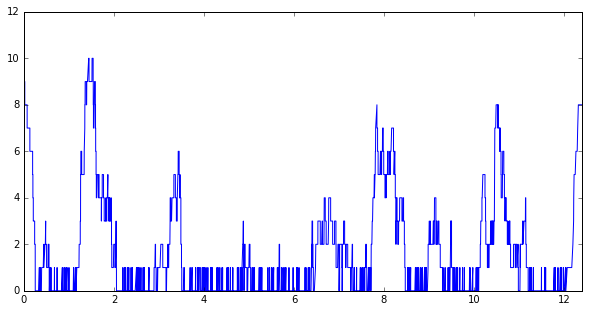

In [159]:
# DO NOT MODIFY THIS CELL
# Plot the number of cars available at parking lot (0) versus time
x,y=get_xy_stateVarList(stateVarList,1,0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y,'b')
ax.set_xlim((0,np.max(x)))
ax.set_ylim((0,np.max(y)*1.2))
#x0,x1 = ax.get_xlim()
#y0,y1 = ax.get_ylim()
#ax.set_aspect(1.0)
#ax.grid(b=True, which='major', linestyle='--')
plt.show()

## TASK : Plot the number of customers queing at parking lot (1) versus time  

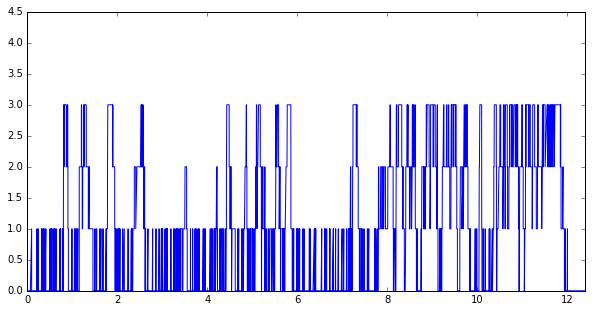

In [160]:
#your code here
x,y=get_xy_stateVarList(stateVarList,2,1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y,'b')
ax.set_xlim((0,np.max(x)))
ax.set_ylim((0,np.max(y)*1.5))
plt.show()

In [161]:
# DO NOT MODIFY THIS CELL
#Calculate time averaged stats
def get_TimeAveragedStats(sL,j,n):
    # sL = stateList
    # j = variable to average
    # n = pointer to nodes {0,1,2}
    # return time averaged j
    i=1
    totalArea=0
    while i<len(sL):
        dT = sL[i][0] - sL[i-1][0]
        totalArea += dT*float(sL[i-1][j][n])
        i += 1
    totalTime=sL[len(sL)-1][0] - sL[0][0]
    mean = totalArea/totalTime
    return mean

In [162]:
# DO NOT MODIFY THIS CELL
# Compute average queue length at parking lot (2) 
get_TimeAveragedStats(stateVarList,2,2)

1.1056470777601246

## TASK : Compute the time-averaged number of cars and queue lengths at each parking lot  

In [163]:
print "Average Queue Length At Parking Lot 0: ",get_TimeAveragedStats(stateVarList,2,0)
print "Average Queue Length At Parking Lot 1: ",get_TimeAveragedStats(stateVarList,2,1)
print "Average Queue Length At Parking Lot 2: ",get_TimeAveragedStats(stateVarList,2,2)
print "Average Number Of Cars At parking Lot 0: ",get_TimeAveragedStats(stateVarList,1,0)
print "Average Number Of Cars At parking Lot 1: ",get_TimeAveragedStats(stateVarList,1,1)
print "Average Number Of Cars At parking Lot 2: ",get_TimeAveragedStats(stateVarList,1,2)

Average Queue Length At Parking Lot 0:  0.862917046024
Average Queue Length At Parking Lot 1:  0.902829637365
Average Queue Length At Parking Lot 2:  1.10564707776
Average Number Of Cars At parking Lot 0:  1.52706646484
Average Number Of Cars At parking Lot 1:  1.55606833588
Average Number Of Cars At parking Lot 2:  1.30354324598


## TASK : Run the simulation 100 times and find the mean and standard deviation for:
1. The blocking-rate at each parking lot.
1. Residual number of cars at each parking lot at the end of a day.
1. Time-averaged number of cars at each parking lot. 
1. Time-averaged queue lengths at each parking lot. 

In [164]:
# DO NOT MODIFY THIS CELL
#
def get_vector_stats(ddata,j):
    # ddata = list containing data in rows and cols
    # j = column to average
    # return mean and stdev j
    x = np.empty(len(ddata),dtype=float)
    for i in range(len(x)):
        x[i]=ddata[i][j]
    x_mean = np.mean(x)
    x_stdev = np.std(x)
    return x_mean,x_stdev
    #return x

In [175]:
statistics = []
currentRunStats = []

for count in range (5):
    fileOutA=True   # Flag, if true output to file
    stateVarList=[]    # List containing [time, N(t), q(t)]
    servTimeList=[]
    eventList=[]    # Event calendar list
    notice=[]       # notice = [ notice number, time, type, [parameters] ]
                    # type = 0, arrival
                    # type = 1, begin service
                    # type = 2, end service
                    # param 0 = orgin/destination node
    now = 0.0       # Simulation time
    #
    end_of_sim = 12.0 # time end of generating requests
    #
    #Network of nodes definition
    # service area 10km x 10km
    service_node = np.array([[1,1], 
                     [9,5], 
                     [3,9]])
    Z = np.shape(service_node)[0]           # number of nodes
    time_to_travel=np.empty([Z,Z],dtype=float)
    for i in range(Z):
        for j in range(Z):
            time_to_travel[i,j]=get_trip_time(i,j)
    #
    Qmax=3          # request blocked if Q=>Qmax
    Q=[]            # Queue Length at node z, Q=0 when empty
    for i in range(Z):
        Q.append(0)
    N=[]            # Number of resources at node z
    for i in range(Z):
        N.append(10)

    # variables for collecting stats
    tot_no_arrivals=0
    blocked=0
    Blocked = []
    for i in range(Z):
        Blocked.append(0)


    # Schedule arrival event at time NOW;
    EN=0            # Event Notice Number
    notice=[EN, now, 0,[generate_Origin_node(Z)]]
    ScheduleEventNotice(notice)
    
    while (eventList!=[] and now<30): #30 is a constant upper limit
        now = eventList[0][1]
        #print now,'   ',eventList[0]
        #print now, 'Q = ',Q, '   N = ',N
        #DisplayEventList('Hello')
        if eventList[0][2]==0:
            EventRoutineArrival(eventList[0][3])
        elif eventList[0][2]==1:
            EventRoutineBeginService(eventList[0][3])
        elif eventList[0][2]==2:
            EventRoutineEndService(eventList[0][3])
        else:
            print 'Unknown event type'
        #Remove first notice
        eventList.pop(0)
        #DisplayEventList("EventList")
    
    currentRunStats = [get_blockingRate(Blocked[0],tot_no_arrivals),get_blockingRate(Blocked[1],tot_no_arrivals),get_blockingRate(Blocked[2],tot_no_arrivals),
                              N[0], N[1],N[2], 
                              get_TimeAveragedStats(stateVarList,1,0),get_TimeAveragedStats(stateVarList,1,1),get_TimeAveragedStats(stateVarList,1,2),
                              get_TimeAveragedStats(stateVarList,2,0),get_TimeAveragedStats(stateVarList,2,1),get_TimeAveragedStats(stateVarList,2,2)]
    statistics.append(currentRunStats)  
    
def getStatsBlockRate(statistics):
    mean,stdDev = get_vector_stats(statistics,0)
    print "Mean Block Rate At Parking Lot 0: ", mean
    print "Standard Deviation At Parking Lot 0: ", stdDev
    mean,stdDev = get_vector_stats(statistics,1)
    print "Mean Block Rate At Parking Lot 1: ", mean
    print "Standard Deviation At Parking Lot 1: ", stdDev
    mean,stdDev = get_vector_stats(statistics,2)
    print "Mean Block Rate At Parking Lot 2: ", mean
    print "Standard Deviation At Parking Lot 2: ", stdDev, "\n"

def getResCars(statistics):
    mean,stdDev = get_vector_stats(statistics,3)
    print "Mean Residual Cars At Parking Lot 0: ", mean
    print "Standard Deviation At Parking Lot 0: ", stdDev
    mean,stdDev = get_vector_stats(statistics,4)
    print "Mean Residual Cars At Parking Lot 1: ", mean
    print "Standard Deviation At Parking Lot 1: ", stdDev
    mean,stdDev = get_vector_stats(statistics,5)
    print "Mean Residual Cars At Parking Lot 2: ", mean
    print "Standard Deviation At Parking Lot 2: ", stdDev, "\n"

def getAvrgNoCars(statistics):
    mean,stdDev = get_vector_stats(statistics,6)
    print "Mean Average Number of Cars At Parking Lot 0: ", mean
    print "Standard Deviation At Parking Lot 0: ", stdDev
    mean,stdDev = get_vector_stats(statistics,7)
    print "Mean Average Number of Cars At Parking Lot 1: ", mean
    print "Standard Deviation At Parking Lot 1: ", stdDev
    mean,stdDev = get_vector_stats(statistics,8)
    print "Mean Average Number of Cars At Parking Lot 2: ", mean
    print "Standard Deviation At Parking Lot 2: ", stdDev,"\n"

def getAvrgQLen(statistics):
    mean,stdDev = get_vector_stats(statistics,6)
    print "Mean Average Queue Length At Parking Lot 0: ", mean
    print "Standard Deviation At Parking Lot 0: ", stdDev
    mean,stdDev = get_vector_stats(statistics,7)
    print "Mean Average Queue Length At Parking Lot 1: ", mean
    print "Standard Deviation At Parking Lot 1: ", stdDev
    mean,stdDev = get_vector_stats(statistics,8)
    print "Mean Average Queue Length At Parking Lot 2: ", mean
    print "Standard Deviation At Parking Lot 2: ", stdDev

getStatsBlockRate(statistics)
getResCars(statistics)
getAvrgNoCars(statistics)
getAvrgQLen(statistics)
    

Mean Block Rate At Parking Lot 0:  5.4274340942
Standard Deviation At Parking Lot 0:  1.40750951288
Mean Block Rate At Parking Lot 1:  6.53028170296
Standard Deviation At Parking Lot 1:  1.34595826513
Mean Block Rate At Parking Lot 2:  5.82691004262
Standard Deviation At Parking Lot 2:  1.81908786004 

Mean Residual Cars At Parking Lot 0:  9.6
Standard Deviation At Parking Lot 0:  2.33238075794
Mean Residual Cars At Parking Lot 1:  11.4
Standard Deviation At Parking Lot 1:  3.2
Mean Residual Cars At Parking Lot 2:  9.0
Standard Deviation At Parking Lot 2:  2.19089023002 

Mean Average Number of Cars At Parking Lot 0:  1.32234210791
Standard Deviation At Parking Lot 0:  0.484637135242
Mean Average Number of Cars At Parking Lot 1:  1.36480481398
Standard Deviation At Parking Lot 1:  0.237866390802
Mean Average Number of Cars At Parking Lot 2:  1.43277192738
Standard Deviation At Parking Lot 2:  0.502536363639 

Mean Average Queue Length At Parking Lot 0:  1.32234210791
Standard Deviation